# News Classification Project

In this project, I'll work with text data from newsgroup postings. I'll train classifiers to distinguish between the topics based on the text of the posts. Each document will be represented with a "bag-of-words" model. This makes the feature representation quite sparse. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

In this school project, the number of packages we were allowed to use was restricted.


In [7]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. I further split the test so we have a dev set. Note that I specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('test label shape:', test_labels.shape)
print('dev label shape:', dev_labels.shape)
print('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1: Explore the Data

For each of the first 5 training examples, print the text of the message along with the label.

In [8]:
#This is a function to print user specified number of examples of training data and training labels

def P1(num_examples=5):
    #Iterate over range of number of examples given to print Train Data and Train Label
    for i in range(num_examples):
        print('Train Data #'+str(i+1))
        print(train_data[i])
        print('\n')
        print('Train Label #'+ str(i+1))
        print(train_labels[i])
        print('\n')
        print('\n')
        print('\n')
P1(5)


Train Data #1
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


Train Label #1
1






Train Data #2


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.


Train 

### Part 2: Explore the Features

Use CountVectorizer to turn the raw training text into feature vectors. I use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. 

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? 

b. What are the 0th and last feature strings (in alphabetical order)?

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? 

In [5]:

#Part 2

from sklearn.feature_extraction.text import CountVectorizer


#instantiate the class
cvect = CountVectorizer()

#create a document term matrix 
dtm = cvect.fit_transform(train_data)

#Question 2a : What is the size of the vocabulary? 
dtm.get_shape()
print('Answer to 2a : Size of the vocabulary is 26879 using default count vectorizer options.')

#Question 2a : What is the average number of non-zero features per example? 
av = dtm.nnz / dtm.get_shape()[0]
av
print('Answer to 2a: The average number of non-zero features per example is 97.')

#Question 2a : What fraction of the entries in the matrix are non-zero? 
fract = dtm.nnz / (dtm.get_shape()[0] * dtm.get_shape()[1])
fract
print('Answer to 2a : The fraction of non-zero entries is 0.0035978272269590263.')

#Question 2b : What are the 0th and last feature strings (in alphabetical order)?

cvect.get_feature_names()[0]
cvect.get_feature_names()[26878]

print("Answer to 2b : the 0th feature is '00' and the last feature is 'zyxel' ")


#Question 2c : Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. 
#Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

vocab_list = ["atheism", "graphics", "space", "religion"]

cvect2 = CountVectorizer(vocabulary = vocab_list)
dtm2 = cvect2.fit_transform(train_data)

#Double check that we only have 4 words in the vocabulary
print('Check that we only have 4 words in vocabulary:')
print(cvect2.vocabulary_)

#Check shape of DTM2 training vector
print('Answer to 2c : Check shape of training vector ' + str(dtm2.get_shape()))
#Answer : Shape is now (2034, 4)

av2 = dtm2.nnz / 2034
av2

print(' Answer to 2c : Average number of non-zero features is now 0.26843657817109146. ')


# Question 2d : Instead of extracting unigram word features, 
#use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

cvect3 = CountVectorizer(ngram_range=(2, 3), analyzer='char')
dtm3 = cvect3.fit_transform(train_data)
dtm3.get_shape()

print( 'Answer to 2d : Vocabulary size is now 35478.')


#Question 2e : Use the "min_df" argument to prune words that appear in fewer than 10 documents. 
#What size vocabulary does this yield?

cvect4 = CountVectorizer(min_df =10)
dtm4 = cvect4.fit_transform(train_data)
dtm4.get_shape()

print(' Answer to 2e : Vocabulary size is now 3064 ' )

#Question 2f : Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the 
#vocabulary? 


cvect5 = CountVectorizer()
dtm5 = cvect5.fit_transform(dev_data)
dtm5.get_shape()

#Find values that do not exist in both dev and training vocab - the difference
value = { k : cvect5.vocabulary_[k] for k in set(cvect5.vocabulary_) - set(cvect.vocabulary_) }

ans2f = len(value) / dtm5.get_shape()[1]


print( ' Answer to 2f : 0.24787640034470024 values are in dev data but not training data. ' )



Answer to 2a : Size of the vocabulary is 26879 using default count vectorizer options.
Answer to 2a: The average number of non-zero features per example is 97.
Answer to 2a : The fraction of non-zero entries is 0.0035978272269590263.
Answer to 2b : the 0th feature is '00' and the last feature is 'zyxel' 
Check that we only have 4 words in vocabulary:
{'atheism': 0, 'graphics': 1, 'space': 2, 'religion': 3}
Answer to 2c : Check shape of training vector (2034, 4)
 Answer to 2c : Average number of non-zero features is now 0.26843657817109146. 
Answer to 2d : Vocabulary size is now 35478.
 Answer to 2e : Vocabulary size is now 3064 
 Answer to 2f : 0.24787640034470024 values are in dev data but not training data. 


### Part 3: Explore and Evaluate Different Models

Use the default CountVectorizer options. Report the f1 score for a k nearest neighbors classifier and find the optimal value for k. 

Fit the data on a Multinomial Naive Bayes model and find the optimal value for alpha. 

Fit the data to a logistic regression model. Check for the optimal value for the regularization strength C using l2 regularization. 

Finally, evaluate and explain the performance of the models :

* Explain why nearest neighbors does not work well for this problem.
* Explain why Logistic Regression does not work as well as Naive Bayes.
* Logistic regression estimates a weight vector for each class, which can be accessed with the coef\_ attribute. 
* Provide the sum of the squared weight values for each class for each setting of the C parameter and explain the relationship between the sum and the value of C.

In [6]:
#Part 3 

#instantiate the class
cvect = CountVectorizer()

#create a document term matrix from reviews
X_train = cvect.fit_transform(train_data)
y_train = train_labels

X_dev = cvect.transform(dev_data)
y_dev = dev_labels

#Question : Use the default CountVectorizer options and report the f1 score for KNN.
#Find the optimal value for k.

#K nearest neighbours

#Create list of k values to test
k_values =[1, 3, 5, 7, 9]

#Create a search function to find the best k values that optimizes the weighted f1-score in KNN model
def search_k(k_values):
    #create empty list to store f1 scores for each k value
    f1s=[]
    # run through list of k values provided
    for i in k_values:
        #Use KNeighborsClassifier to produce model
        knn = KNeighborsClassifier(n_neighbors=i, p=2, metric ='minkowski')
        knn.fit(X_train,y_train)
        y_pred_knn = knn.predict(X_dev)
        
        #Append f1 scores for each k value
        f1s.append(metrics.f1_score(y_dev, y_pred_knn, average='weighted'))
        
    #Find the max index position for f1s and find the associated k-value for that
    best_k = k_values[f1s.index(max(f1s))]
        
    return best_k

#Run code for various k values to find answer of best k value
best_k = search_k(k_values)
print('The best k value for the KNN model is ' + str(best_k))

#Show F1-Score for k value in KNN model
knn = KNeighborsClassifier(n_neighbors=7, p=2, metric ='minkowski')
knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_dev)
print('F1 score of KNN Model with k=7 is ' + str(metrics.f1_score(y_dev, y_pred_knn, average='weighted')))
# Answer : The weighted f1-score of the KNN classifier with 7 nearest neighbors is 0.45


# Question  fit a Multinomial Naive Bayes model and find the optimal value for alpha. 

#Multinomial Classifier

#Create list of alpha values to test
alphas = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]

#Create a search function to find the best alpha that optimizes the weighted f1-score in Multinomial Naive Bayes
def search_a(alphas):
    #create empty list to store f1 scores for each k value
    f1s=[]
    
    # run through list of alpha values provided
    for i in alphas:
        
        #Use Multinomial Naive Bayes to produce model
        mn_model =  MultinomialNB(alpha = i)
        mn_model.fit(X_train,y_train)
        y_pred_mn = mn_model.predict(X_dev)
        
         #Append f1 scores for each alpha value
        f1s.append(metrics.f1_score(y_dev, y_pred_mn, average='weighted'))
        
    #Find the max index position for f1s and find the associated alpha-value for that
    best_alpha = alphas[f1s.index(max(f1s))]
    return best_alpha

#Run code for various alpha values to find answer of best alpha value
best_alpha = search_a(alphas)

print('The best alpha value for the Multinomial NB model is ' + str(best_alpha))


#Show F1-Score for alpha value in Multinomial model

mn_model =  MultinomialNB(alpha = 0.1)
mn_model.fit(X_train,y_train)
y_pred_mn = mn_model.predict(X_dev)
print('F1 score of Multinomial Model with 0.1 alpha is ' + str(metrics.f1_score(y_dev, y_pred_mn, average='weighted')))


#Question : Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

#Logistic Regression

#Create list of Regularization C values to test
C_values = np.logspace(-4, 4, 20)

#Create a search function to find the best C values that optimizes the weighted f1-score in Logistic Regression Model
def search_c(C_values):
    
    #create empty list to store f1 scores for each k value
    f1s=[]
    
    # run through list of C values provided
    for i in C_values:
        
        #Use Logistic Regression to produce model
        lgr = LogisticRegression(solver='lbfgs', random_state=24, multi_class='multinomial' , C = i, max_iter =10000, penalty = 'l2')
        lgr.fit(X_train,y_train)
        y_pred_lgr = lgr.predict(X_dev)
        
        #Append f1 scores for each C value
        f1s.append(metrics.f1_score(y_dev, y_pred_lgr, average='weighted'))
    
    #Find max index position for f1s and find the associated C-value for that
    best_C = C_values[f1s.index(max(f1s))]
        
    return best_C

#Run code for various C values to find answer of best C value
best_C = search_c(C_values)

print('The best C value for the Logistic Regression model is ' + str(best_C))

#Show F1-Score for C value in Logistic Regression model

lgr = LogisticRegression(solver='lbfgs', random_state=24, multi_class='multinomial' , C = best_C, max_iter =10000, penalty = 'l2')
lgr.fit(X_train,y_train)
y_pred_lgr = lgr.predict(X_dev)
print('F1 score of Logistic Regression with C value of ' + str(best_C) + ' is ' + str(metrics.f1_score(y_dev, y_pred_lgr, average='weighted')))



The best k value for the KNN model is 7
F1 score of KNN Model with k=7 is 0.45047910006117586
The best alpha value for the Multinomial NB model is 0.1
F1 score of Multinomial Model with 0.1 alpha is 0.7903052385098862
The best C value for the Logistic Regression model is 0.08858667904100823
F1 score of Logistic Regression with C value of 0.08858667904100823 is 0.6984129947106409


In [6]:
#Part 3 Continued
# Question : Output the sum of the squared weight values for each class for each setting of the C parameter.

#Create list of Regularization C values to test
C_values = np.logspace(-4, 4, 20)

#Create a function to output the sum of the squared weight values for each class for each setting of the C parameter

def ss_weights(C_values):
    for i in C_values:
        #Use Logistic Regression to produce model
        lgr = LogisticRegression(solver='lbfgs', random_state=24, multi_class='multinomial' , C = i, max_iter =10000, penalty = 'l2')
        lgr.fit(X_train,y_train)
        y_pred_lgr = lgr.predict(X_dev)
        #Store the coefficients per category under log_odds variable
        log_odds = lgr.coef_

        #Create an empty list to store sum of squared values
        category_ss_weights = []

        #write function to calculate sum of squared weights per category
        for k in range(len(lgr.coef_)):
            category_ss_weights.append(sum( i*i for i in log_odds[k]))
        
        #Answer : These are the sum of squared weights for categories 0 - 3 respectively for the C value being tested.
        print('This is the sum of squared category weights for category 0-3 for C value = ' + str(i) + ' : ' +str(category_ss_weights))
        print('\n')
        
ss_weights(C_values)


This is the sum of squared category weights for category 0-3 for C value = 0.0001 : [0.004025267439554586, 0.005953951352205467, 0.005203435234846373, 0.0036309314810778815]


This is the sum of squared category weights for category 0-3 for C value = 0.00026366508987303583 : [0.015542313926393256, 0.024513050612436398, 0.020329692861695177, 0.014636673389270907]


This is the sum of squared category weights for category 0-3 for C value = 0.0006951927961775605 : [0.05824470445940327, 0.09763149718145041, 0.07715723515523433, 0.054838565473979]


This is the sum of squared category weights for category 0-3 for C value = 0.0018329807108324356 : [0.20588367811248187, 0.3324883796195552, 0.2704934729878028, 0.18951764547540773]


This is the sum of squared category weights for category 0-3 for C value = 0.004832930238571752 : [0.6710597083218652, 0.9789666781042493, 0.850883572848737, 0.6050156803465618]


This is the sum of squared category weights for category 0-3 for C value = 0.01274274

### Question : Why doesn't nearest neighbors work well for this problem?

Answer : 

1. K nearest neighbours algorithm does not work well when we have a high dimensional data set like this one where number of features is greater than number of observations. This is due to the curse of dimensionality as number of dimensions increases the number of observations must increase exponentially otherwise the performance of the model deteriorates. 

2. It also does not have the capability to deal with the large number of 0 or missing values for features.

3. Lastly, running the model would be slower if you need that many observations to maintain the performance of the model.


### Question : Any ideas why logistic regression doesn't work as well as Naive Bayes?

Answer :
1. Naive Bayes outperforms Logistic Regression when encountering missing values and sparse data. The Naive Bayes algorithm assumes features are independent and ignores missing attributes when calculating probabilities.

### Question : Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Briefly explain the relationship between the sum and the value of C.
 
Answer:
- The C value is the inverse of regularization strength.

- The smaller the C value, the larger the regularization strength, and the the sum of squared weights is lower because it is less likely that they will increase in magnitude to adjust for the high dimensional, sparse data. This reduces overfitting.

- On the other hand. the larger the C value, the smaller the regularization strength and the sum of squared weights is higher because it is more likely that they will increase in magnitude to adjust for high dimensional, sparse data which may lead to overfitting.

### Part 4: Review Feature Weights

Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create an array with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the array again with bigram features. Any surprising features in this array?

In [9]:
#Part 4 Answer

#pandas not present in the imported libraries hence have to create list of lists instead

def create_lgrtab(ngram):
    
    #instantiate the class
    cvect = CountVectorizer(ngram_range=(ngram, ngram), analyzer='word')

    #create a document term matrix from reviews
    X_train = cvect.fit_transform(train_data)
    y_train = train_labels

    #Create model for LGR
    lgr = LogisticRegression(solver='lbfgs', random_state=24, multi_class='multinomial' , C = best_C , max_iter =10000, penalty = 'l2')
    lgr.fit(X_train,y_train)
    
    #Get list of feature names
    features = cvect.get_feature_names()
    
    #Get LGR weights
    log_odds = lgr.coef_
    
    #Create feature weights table per Topic
    feat = [['','Topic 0','Topic 1','Topic 2','Topic 3']]

    #For each topic, append the feature name and the weight for that Topic, zero for other topics
    for i in range(4):
        #Where category is 0
        if i == 0 :
            #find top 5 index position taken from the back since this is sorted in ascending order
            ind = np.argpartition(log_odds[i], -5)[-5:]

            #append feature name then append weight of feature for in first col for Category 0, put in zeros for all other columns
            for k in ind:
                feat.append([features[k],log_odds[i][k],0,0,0])
                
        #Do the same for Category 1 , 2 and 3 below
        elif i == 1 :
            ind = np.argpartition(log_odds[i], -5)[-5:]

            for k in ind:
                feat.append([features[k],0,log_odds[i][k],0,0])    

        elif i == 2 :                  
            ind = np.argpartition(log_odds[i], -5)[-5:]

            for k in ind:
                feat.append([features[k],0,0,log_odds[i][k],0])    

        elif i == 3 :                  
            ind = np.argpartition(log_odds[i], -5)[-5:]

            for k in ind:
                feat.append([features[k],0,0,0,log_odds[i][k]])                             
    
    return feat


#Answer 
unigram_feat_table = create_lgrtab(1)

print(unigram_feat_table)
print('\n')

bigram_feat_table = create_lgrtab(2)

print(bigram_feat_table)



[['', 'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3'], ['islam', 0.2778805368986349, 0, 0, 0], ['bobby', 0.3254434678946128, 0, 0, 0], ['atheists', 0.33650662066960696, 0, 0, 0], ['religion', 0.39096694692061285, 0, 0, 0], ['atheism', 0.3648930286945801, 0, 0, 0], ['files', 0, 0.38041555377283637, 0, 0], ['3d', 0, 0.4029991229868458, 0, 0], ['image', 0, 0.48848262123848907, 0, 0], ['graphics', 0, 0.738823116196495, 0, 0], ['file', 0, 0.4810699723074281, 0, 0], ['spacecraft', 0, 0, 0.28865867664045514, 0], ['orbit', 0, 0, 0.43486141444103316, 0], ['nasa', 0, 0, 0.42477960496665457, 0], ['launch', 0, 0, 0.33900899375959526, 0], ['space', 0, 0, 0.9672236029620377, 0], ['koresh', 0, 0, 0, 0.30409541765716835], ['objective', 0, 0, 0, 0.31621880086523896], ['christian', 0, 0, 0, 0.3932239758112145], ['god', 0, 0, 0, 0.39835469324577877], ['christians', 0, 0, 0, 0.40124648952728265]]


[['', 'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3'], ['are you', 0.22118990338944952, 0, 0, 0], ['in this', 0.2286

In [8]:
unigram_array = np.array(unigram_feat_table, dtype=object) 
unigram_array = unigram_array.astype('U')
unigram_array

array([['', 'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3'],
       ['islam', '0.2778805368986349', '0', '0', '0'],
       ['bobby', '0.3254434678946128', '0', '0', '0'],
       ['atheists', '0.33650662066960696', '0', '0', '0'],
       ['religion', '0.39096694692061285', '0', '0', '0'],
       ['atheism', '0.3648930286945801', '0', '0', '0'],
       ['files', '0', '0.38041555377283637', '0', '0'],
       ['3d', '0', '0.4029991229868458', '0', '0'],
       ['image', '0', '0.48848262123848907', '0', '0'],
       ['graphics', '0', '0.738823116196495', '0', '0'],
       ['file', '0', '0.4810699723074281', '0', '0'],
       ['spacecraft', '0', '0', '0.28865867664045514', '0'],
       ['orbit', '0', '0', '0.43486141444103316', '0'],
       ['nasa', '0', '0', '0.42477960496665457', '0'],
       ['launch', '0', '0', '0.33900899375959526', '0'],
       ['space', '0', '0', '0.9672236029620377', '0'],
       ['koresh', '0', '0', '0', '0.30409541765716835'],
       ['objective', '0', '0', '0', '0.316

In [9]:
bigram_array = np.array(bigram_feat_table, dtype=object) 
bigram_array = bigram_array.astype('U')
bigram_array

array([['', 'Topic 0', 'Topic 1', 'Topic 2', 'Topic 3'],
       ['are you', '0.22118990338944952', '0', '0', '0'],
       ['in this', '0.22862236143860015', '0', '0', '0'],
       ['is not', '0.23134911422195706', '0', '0', '0'],
       ['cheers kent', '0.25466419202268725', '0', '0', '0'],
       ['you are', '0.23661683527192667', '0', '0', '0'],
       ['comp graphics', '0', '0.294079512548333', '0', '0'],
       ['is there', '0', '0.32974345308766745', '0', '0'],
       ['out there', '0', '0.35073232039122715', '0', '0'],
       ['in advance', '0', '0.40995505196049536', '0', '0'],
       ['looking for', '0', '0.5303963177363488', '0', '0'],
       ['it was', '0', '0', '0.26653571847223617', '0'],
       ['and such', '0', '0', '0.27107824556569576', '0'],
       ['sci space', '0', '0', '0.27325187320738414', '0'],
       ['the space', '0', '0', '0.37759950493812056', '0'],
       ['the moon', '0', '0', '0.3903350334801197', '0'],
       ['of god', '0', '0', '0', '0.1970498681533393'

### ANSWER:

Some surprising features in the bigram table include 'are you' , 'in  this', 'is not', 'you are' , 'is there' and 'it was'. These are generic non-unique bigrams that can be found in english sentences across multiple topics.

### Part 5: Improve the F1 Score with Pre-Processing

Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [10]:
#Part 5 

# For example, try lowercasing everything, replacing sequences of numbers with a single token, 
#removing various other non-letter characters, and shortening long words.

stopwords=['this','that','and','a','we','it','to','is','of','up','need','you','are','was','there','the']


def custom_preprocessor(text):
   
    #Noise removal
    #removes non-word characters - reduces F1
    text=re.sub("\\W"," ",text)
    
    #Noise removal
    #replace numbers with 3 or more digits with token "number"
    text=re.sub("\d{3,}","number",text)
    
    #Noise removal
    #Removes symbols and punctuation characters
    text=re.sub("[^A-Za-z0-9 ]+"," ",text)

    #Noise removal
    #Remove all numbers
    text=re.sub("[\d-]"," ",text)
   
    #Lemmatization and Stemming
    text=re.sub("ing$|s$|es$|ly$|$ism|$ed"," ",text)
   
    #truncate
    #text = re.sub("(\w{%d})\w+" % 7, "\\1", text)

    #Split text into words
    words=text.split(" ")
    shortlisted_words=[]
        
    #More Stemming and Remove Stopwords
    #Truncate LONG WORDS longer than or equal to 7 , Removing Stop Words and removing words 2 characters or less
    for w in words:
        if len(w) >= 7:
            w = w.lower()[:6]
            if w in stopwords or len(w) <= 2 :
                w=""
            else:
                shortlisted_words.append(w)
        else:
            w = w.lower()
            if w in stopwords or len(w) <= 2:
                w=""
            else:
                shortlisted_words.append(w)

    
    text = " ".join(shortlisted_words)
    
    return text

#Show F1-Score for C value in Logistic Regression model Before Text Pre-Processing via REGEX

#instantiate count vectorizer (no preprocessing)
cvect = CountVectorizer(lowercase = False, token_pattern=r'(?u)\b\w+\b')

#Document term matrix for training data (no preprocessing) and development data
X_train = cvect.fit_transform(train_data)
y_train = train_labels
X_dev = cvect.transform(dev_data)
y_dev = dev_labels
features = cvect.get_feature_names()

#Create list of Regularization C values to test
c_values = np.logspace(0, 4, 10)

#Create a search function to find the best C values that optimizes the weighted f1-score in Pre-Processed Logistic Regression Model
def search_c0(c_values):
    
    #create empty list to store f1 scores for each k value
    f1s=[]
    
    # run through list of C values provided
    for i in c_values:
        
        #Use Logistic Regression to produce model
        lgr = LogisticRegression(solver='lbfgs', random_state=24, multi_class='multinomial', C= i,  max_iter =10000, penalty = 'l2')
        lgr.fit(X_train,y_train)
        y_pred_lgr = lgr.predict(X_dev)
        
        #Append f1 scores for each C value
        f1s.append(metrics.f1_score(y_dev, y_pred_lgr, average='weighted'))
    
    #Find max index position of f1 values and find associated c value
    best_c = c_values[f1s.index(max(f1s))]
        
    return best_c

#Run code for various C values to find answer of best C value
best_c0 = search_c0(c_values)

#Create LGR Model
lgr = LogisticRegression(solver='lbfgs', random_state=24, multi_class='multinomial' , C = best_c0, max_iter =10000, penalty = 'l2')
lgr.fit(X_train,y_train)
y_pred_lgr = lgr.predict(X_dev)
print('F1 score of Logistic Regression BEFORE Regex Pre-Processing ' + ' is ' + str(metrics.f1_score(y_dev, y_pred_lgr, average='weighted')))
print('Length of vocab before Pre-Processing is ' + str(len(features)))


#Now Show F1-Score for C value in Logistic Regression model After Text Pre-Processing via REGEX

#Instantiate count vectorizer with preprocesser
cvecta = CountVectorizer(train_data, preprocessor=custom_preprocessor)

#DTM for training data
X_traina = cvecta.fit_transform(train_data)
y_traina = train_labels
features_a = cvecta.get_feature_names()

#Preprocess dev data using vocabulary from training data
cvecta_dev = CountVectorizer(preprocessor=custom_preprocessor, vocabulary = features_a)
X_deva = cvecta_dev.fit_transform(dev_data)
###X_deva = cvecta_dev.transform(dev_data)
y_deva = dev_labels


#Create list of Regularization C values to test
c_values = np.logspace(0, 4, 10)

#Create a search function to find the best C values that optimizes the weighted f1-score in Pre-Processed Logistic Regression Model
def search_c1(c_values):
    
    #create empty list to store f1 scores for each k value
    f1s=[]
    
    # run through list of C values provided
    for i in c_values:
        
        #Use Logistic Regression to produce model
        lgra = LogisticRegression(solver='lbfgs', random_state=24, multi_class='multinomial', C= i,  max_iter =10000, penalty = 'l2')
        lgra.fit(X_traina,y_traina)
        y_pred_lgra = lgra.predict(X_deva)
        
        #Append f1 scores for each C value
        f1s.append(metrics.f1_score(y_deva, y_pred_lgra, average='weighted'))
    
    #Find max index position of f1 values and find associated c value
    best_c = c_values[f1s.index(max(f1s))]
        
    return best_c

#Run code for various C values to find answer of best C value
best_c1 = search_c1(c_values)

lgra = LogisticRegression(solver='lbfgs', random_state=24, multi_class='multinomial', C= best_c1,  max_iter =10000, penalty = 'l2')
lgra.fit(X_traina,y_traina)
y_pred_lgra = lgra.predict(X_deva)
print('C value is '+str(best_c1)+' and F1 score of Logistic Regression AFTER Regex Pre-Processing ' + ' is ' + str(metrics.f1_score(y_deva, y_pred_lgra, average='weighted')))
print('Length of vocab after Pre-Processing is ' + str(len(features_a)))

difference = len(features)-len(features_a)

print('Answer : The size of the dictionary was reduced by ' + str(difference))

### STUDENT END ###


F1 score of Logistic Regression BEFORE Regex Pre-Processing  is 0.682382498019506
Length of vocab before Pre-Processing is 33357
C value is 1.0 and F1 score of Logistic Regression AFTER Regex Pre-Processing  is 0.7053843605847561
Length of vocab after Pre-Processing is 17109
Answer : The size of the dictionary was reduced by 16248


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.



In [12]:
#Part 6 

np.random.seed(24)

#Instantiate count vectorizer
cv11 = CountVectorizer()

#DTM matrix creation for training data
x_train11 = cv11.fit_transform(train_data)
y_train11 = train_labels

#Do the same for training data
X_dev_11 = cv11.transform(dev_data)
y_dev_11 = dev_labels

#Create list of c values to test
c_values = np.logspace(0,4,10)

#21.544

#Create list of Regularization C values to test
c_values = np.logspace(0, 4, 10)


In [13]:
#Part 6

#Create a search function to find the best C values that optimizes the weighted f1-score in L1 Regularized Logistic Regression Model
def search_c2(c_values):
    
    #create empty list to store f1 scores for each k value
    f1s=[]
    
    # run through list of C values provided
    for i in c_values:
        
        #Use Logistic Regression to produce model
        lgr_1 = LogisticRegression(solver='saga', random_state=24, tol = 0.015,  multi_class='multinomial' , C =i,  max_iter =10000, penalty = 'l1')
        lgr_1.fit(x_train11, y_train11)
        y_pred_lgr_1 = lgr_1.predict(X_dev_11)
        
        #Append f1 scores for each C value
        f1s.append(metrics.f1_score(y_dev_11, y_pred_lgr_1, average='weighted'))
    
    #Find max index position of f1 values and find associated c value
    best_c = c_values[f1s.index(max(f1s))]
        
    return best_c

#Run code for various C values to find answer of best C value
best_c2 = search_c2(c_values)

print(best_c2)

21.544346900318832


In [14]:

##Part 6 - c-value of 21.544 gives the highest f-1 score of 0.5645 with tolerance set at 0.015 with L1 penalty


#Create LGR Model with L1 Regularization and saga solver
lgr_1 = LogisticRegression(solver='saga', random_state=24, tol = 0.015,  multi_class='multinomial' , C =21.544,  max_iter =10000, penalty = 'l1')
lgr_1.fit(x_train11, y_train11)
y_pred_lgr_1 = lgr_1.predict(X_dev_11)
print('F1 score of Logistic Regression with L1 Regularization and C value ' + str(21.544) + ' is : ' + str(metrics.f1_score(y_dev_11, y_pred_lgr_1, average='weighted')))


#Coefficients for L1 penalty logistic regression with saga solver
coef_l1 = lgr_1.coef_

#Output the number of learned weights that are not equal to zero for LGR with L1 Regularization = 99,837

#Number of non-zeros in weights array of L1 regularized LGR model
nnz_l1 = np.count_nonzero(coef_l1)
print('Answer : The number of non-zeros in the weights of an L1 regularized Logistic Regression model is : ' + str(nnz_l1))


F1 score of Logistic Regression with L1 Regularization and C value 21.544 is : 0.5645991064508887
Answer : The number of non-zeros in the weights of an L1 regularized Logistic Regression model is : 99837


In [15]:
#Part 6 

#Now Check Number of Non-Zero Weights for L2 Regularization using saga solver

#instantiate count vectorizer 
cvect = CountVectorizer()

#Document term matrix for training data 
X_train = cvect.fit_transform(train_data)
y_train = train_labels
X_dev = cvect.transform(dev_data)
y_dev = dev_labels
features = cvect.get_feature_names()

#Create list of Regularization C values to test
c_values = np.logspace(0, 4, 10)


In [16]:
#Part 6 

#Create a search function to find the best C values that optimizes the weighted f1-score Saga Solver l2 Regularized LGR
def search_c_l2(c_values):
    
    #create empty list to store f1 scores for each k value
    f1s=[]
    
    # run through list of C values provided
    for i in c_values:
        
        #Use Logistic Regression to produce model with saga solver
        lgr = LogisticRegression(solver='saga', random_state=24, multi_class='multinomial', C= i,  max_iter =10000, penalty = 'l2')
        lgr.fit(X_train,y_train)
        y_pred_lgr = lgr.predict(X_dev)
        
        #Append f1 scores for each C value
        f1s.append(metrics.f1_score(y_dev, y_pred_lgr, average='weighted'))
    
    #Find max index position of f1 values and find associated c value
    best_c = c_values[f1s.index(max(f1s))]
        
    return best_c

#Run code for various C values to find answer of best C value
best_c_l2 = search_c_l2(c_values)
print(best_c_l2)



1.0


In [17]:
#Part 6

#Best c value for L2 Regularization is 1.0
#Create LGR Model with saga solver
lgr_2 = LogisticRegression(solver='saga', random_state=24, multi_class='multinomial' , C = 1.0, max_iter =10000, penalty = 'l2')
lgr_2.fit(X_train,y_train)
y_pred_lgr_2 = lgr_2.predict(X_dev)
print('F1 score of Logistic Regression with L2 Regularization and C value ' + str(1.0) + ' is : ' + str(metrics.f1_score(y_dev, y_pred_lgr_2, average='weighted')))


#Coefficients for L2 penalty logistic regression with saga solver
coef_l2 = lgr_2.coef_

#Output the number of learned weights that are not equal to zero for LGR with L2 Regularization C value = 1.0

#Number of non-zeros in weights array of L2 regularized LGR model
nnz_l2 = np.count_nonzero(coef_l2)
print('Answer : The number of non-zeros in the weights of an L2 regularized Logistic Regression model is : ' + str(nnz_l2))

difference_nnz = nnz_l2 - nnz_l1

print('Answer : There are ' + str(difference_nnz) + ' more non-zeros in an L2 regularized model compared to an L1 regularized model')

F1 score of Logistic Regression with L2 Regularization and C value 1.0 is : 0.671274181056598
Answer : The number of non-zeros in the weights of an L2 regularized Logistic Regression model is : 107516
Answer : There are 7679 more non-zeros in an L2 regularized model compared to an L1 regularized model


In [18]:
# Get the vocab list for non-zero weight features from an L1 Regularized LGR model

#feature names for L1 data = 26,879
features_l1 = cv11.get_feature_names()

#new vocabulary after removing features with only zero weights 
new_vocab = []

#keep only features with at least on non-zero weight

#holder to move along new_vocab list

for i in range(len(features_l1)):    
    if (coef_l1[0][i] != 0) or (coef_l1[1][i] != 0) or (coef_l1[2][i] != 0) or (coef_l1[3][i] != 0):
        new_vocab.append(features_l1[i])

#length of vocabulary with only features with at least one non-zero weight
print ('Length of new vocab list with at least one non-zero weight is ' + str(len(new_vocab)))



Length of new vocab list with at least one non-zero weight is 26669


In [19]:
#Create List of c values to test
c_values = np.logspace(0,4,10)

#RETRAIN L2 MODEL WITH SMALLER VOCABULAR FROM L1 REGULARIZATION AND NOW WILL REPEAT LOGISTIC REGRESSION WITH L2

cv12 = CountVectorizer(vocabulary = new_vocab)
x_train12 = cv12.fit_transform(train_data)
y_train12 = train_labels

X_dev_12 = cv12.transform(dev_data)
y_dev_12 = dev_labels
c_values = np.logspace(0,4,10)

for i in c_values:
    
    lgr = LogisticRegression(solver='saga', random_state=24,  multi_class='multinomial' , C =i,  max_iter =10000, penalty = 'l2')
    lgr.fit(x_train12, y_train12)
    y_pred_lgr = lgr.predict(X_dev_12)
    f1_score = metrics.f1_score(y_dev_12, y_pred_lgr, average='weighted')
    print ("C value is " + str(i) + " and f-1 score is " + str(f1_score) )
    
    

C value is 1.0 and f-1 score is 0.671274181056598
C value is 2.7825594022071245 and f-1 score is 0.671274181056598
C value is 7.742636826811269 and f-1 score is 0.671274181056598
C value is 21.544346900318832 and f-1 score is 0.671274181056598
C value is 59.94842503189409 and f-1 score is 0.671274181056598
C value is 166.81005372000593 and f-1 score is 0.671274181056598
C value is 464.15888336127773 and f-1 score is 0.671274181056598
C value is 1291.5496650148827 and f-1 score is 0.671274181056598
C value is 3593.813663804626 and f-1 score is 0.671274181056598
C value is 10000.0 and f-1 score is 0.671274181056598


In [20]:
#Create list of c values for plotting
c_values = np.logspace(0, 4, 10)


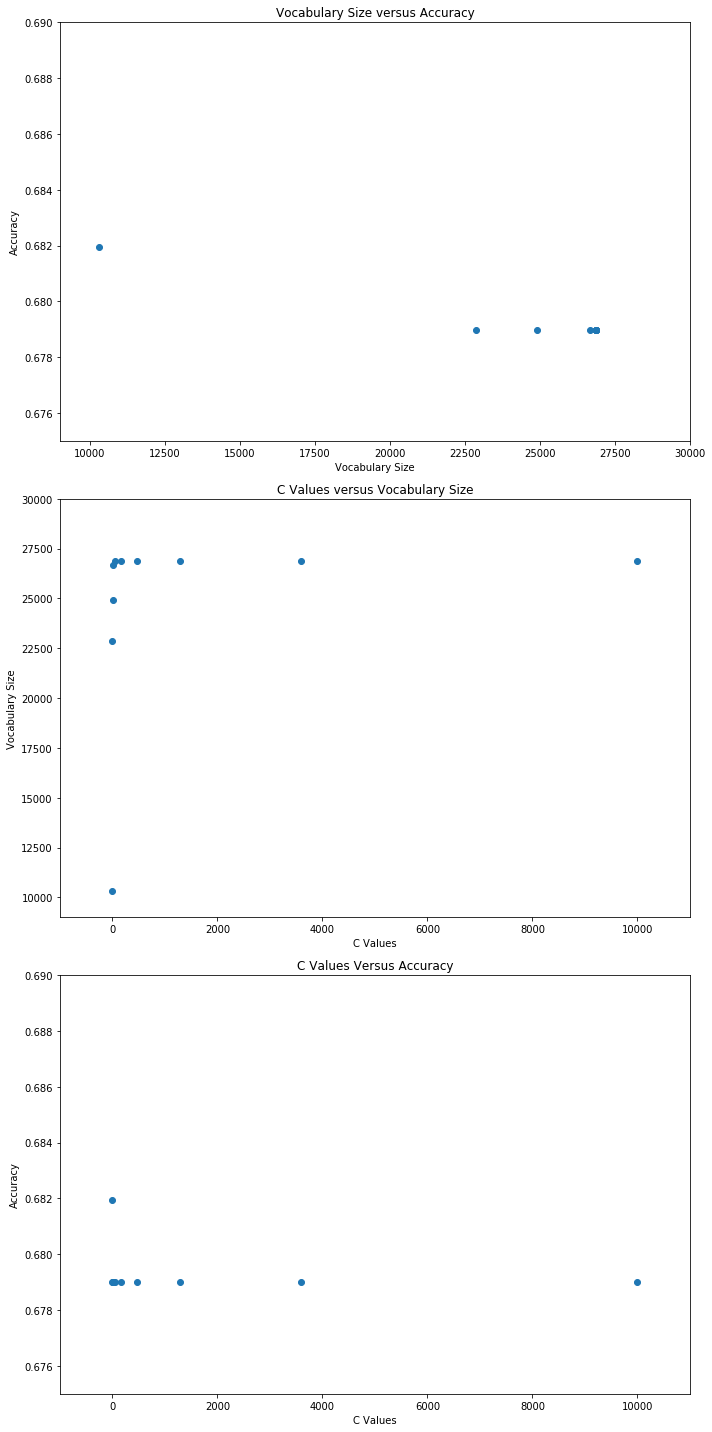

In [21]:
#Make a plot showing accuracy of the re-trained model vs. the vocabulary size you
#get when pruning unused features by adjusting the C parameter.

def P6(c_values):
    np.random.seed(24)
    vocab_size = []
    accuracy = []
    
    for i,c in enumerate(c_values):
        
        #Use L1 Regularizer to prune features
        #Instantiate count vectorizer
        cv11 = CountVectorizer()

        #DTM matrix creation for training data
        x_train11 = cv11.fit_transform(train_data)
        y_train11 = train_labels

        #Do the same for training data
        X_dev_11 = cv11.transform(dev_data)
        y_dev_11 = dev_labels
        
        #Create LGR Model with L1 Regularization and saga solver
        lgr_1 = LogisticRegression(solver='saga', random_state=24, tol = 0.015,  multi_class='multinomial' , C = c,  max_iter =10000, penalty = 'l1')
        lgr_1.fit(x_train11, y_train11)
        y_pred_lgr_1 = lgr_1.predict(X_dev_11)

        #Coefficients for L1 penalty logistic regression with saga solver
        coef_l1 = lgr_1.coef_

        #feature names for L1 data = 26,879
        features_l1 = cv11.get_feature_names()

        #new vocabulary placeholder after removing features with only zero weights 
        new_vocab = []

        #keep only features with at least on non-zero weight

        #create vocab list with non-zero weights under L1
        for f in range(len(features_l1)):    
            if (coef_l1[0][f] != 0) or (coef_l1[1][f] != 0) or (coef_l1[2][f] != 0) or (coef_l1[3][f] != 0):
                new_vocab.append(features_l1[f])

        #Append vocab size to holder
        vocab_size.append(len(new_vocab))
        
        #Create instance for L2 Regularized Model with new vocab and find accuracy
        cv12 = CountVectorizer(vocabulary = new_vocab)
        x_train12 = cv12.fit_transform(train_data)
        y_train12 = train_labels

        X_dev_12 = cv12.transform(dev_data)
        y_dev_12 = dev_labels
        
        #Logistic Regression Model with L2 regularization
        lgr = LogisticRegression(solver='saga', random_state=24,  multi_class='multinomial' , C = c,  max_iter =10000, penalty = 'l2')
        lgr.fit(x_train12, y_train12)
        y_pred_lgr = lgr.predict(X_dev_12)
        accuracy.append(metrics.accuracy_score(y_dev_12, y_pred_lgr, normalize=True))

    # Plot the accuracy of the re-trained model vs. the vocabulary size when pruning unused
    # features by adjusting the C parameter.
    plt.figure(figsize=(10, 20))
    ax = plt.subplot(3, 1, 1)
    
    #Plot Vocabulary Size versus Accuracy
    plt.scatter(vocab_size, accuracy)
    plt.xlabel("Vocabulary Size")
    plt.ylabel("Accuracy")
    plt.title('Vocabulary Size versus Accuracy')
    plt.xlim([9000, 30000])
    plt.ylim([0.675, 0.690])
    
    #Plot C Values versus Vocabulary Size
    ax = plt.subplot(3, 1, 2)
    plt.scatter(c_values, vocab_size)
    plt.xlabel("C Values")
    plt.ylabel("Vocabulary Size")
    plt.title('C Values versus Vocabulary Size')
    plt.xlim([-1000, 11000])
    plt.ylim([9000, 30000])
    
    #Plot C Values versus Accuracy
    ax = plt.subplot(3, 1, 3)
    plt.scatter(c_values, accuracy)
    plt.xlabel("C Values")
    plt.ylabel("Accuracy")
    plt.title('C Values Versus Accuracy')
    plt.xlim([-1000, 11000])
    plt.ylim([0.675, 0.690])
    plt.tight_layout()

P6(c_values)

### Part 7:

Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [22]:
topics = ['Atheism', 'CompGraphics', 'Space', 'Religion']

In [23]:
#Part 7 
### STUDENT START ###


#instantiate the class
tvect = TfidfVectorizer()

#create a document term matrix 
X_train_t = tvect.fit_transform(train_data)
y_train_t = train_labels
X_dev_t = tvect.transform(dev_data)

#Correct Label
y_dev_t = dev_labels

#Train LGR Model with C=100
lgr = LogisticRegression(solver='lbfgs', random_state=24, multi_class='multinomial' , C = 100 , max_iter =10000, penalty = 'l2')
lgr.fit(X_train_t,y_train_t)

#Predicted Label
y_pred_lgr = lgr.predict(X_dev_t)

#Predicted Probabilities for 4 topics across 676 dev samples
lgr_arr_pred = lgr.predict_proba(X_dev_t)

#Get max of probabilities across columns(topics) for each row(676 samples), so 676 max values
max_prob = lgr_arr_pred.max(axis=1)

#Get Predicted Probability of Correct Label
pp_cl = []
for i , l in enumerate(dev_labels):
    pp_cl.append(lgr_arr_pred[i][l])

#Create array to store all R values
r_arr = np.zeros((676,1), dtype=float, order='C')

#Store predicted label and true label
r_ind_list = []

for i in range(len(r_arr)):
    if pp_cl[i]==0:
        r_arr[i] = 0
        r_ind_list.append([y_pred_lgr[i],dev_labels[i]])
    else:
        r_arr[i] = max_prob[i]/lgr_arr_pred[i][dev_labels[i]]
        r_ind_list.append([y_pred_lgr[i],dev_labels[i]])


        
#Find Top 3 documents 

#Write function to get the indices of the docs with the largest R
def largest_indices(array, ndocs):
    #Returns the n largest indices from a numpy array.
    flat_array = array.flatten()
    indices = np.argpartition(flat_array, -ndocs)[-ndocs:]
    #indices = indices[np.argsort(-flat_array[indices])]
    #return np.unravel_index(indices, array.shape)
    return indices
 
top_3_r_ind = largest_indices(r_arr,3)

#Top 3 documents Largest R values across all topics
top_3_r_val =r_arr[top_3_r_ind] 
print('Top 3 R values : ' + str(top_3_r_val))
print('\n')
print('\n')
#top 3 index
top_1 = r_ind_list[top_3_r_ind[0]] 
top_2 = r_ind_list[top_3_r_ind[1]] 
top_3 = r_ind_list[top_3_r_ind[2]] 



# Example 1 : Print X and Y labels of Top 3 (Highest R)
print('Example 1 with R value : ' + str(top_3_r_val[0]))
print('Predicted Label : Topic ' + str(top_1[0]) +' '+ str(topics[top_1[0]]))
print('True Dev Label : ' + str(top_1[1]) +' ' +str(topics[top_1[1]]))
print('Dev Data : ' + str(dev_data[top_3_r_ind[0]]))
print('\n')
print('\n')

# Example 2 : Print X and Y labels of Top 3 (Highest R)
print('Example 2 with R value : ' + str(top_3_r_val[1]))
print('Predicted Label : Topic ' + str(top_2[0]) +' ' + str(topics[top_2[0]]))
print('True Dev Label : ' + str(top_2[1]) +' ' +str(topics[top_2[1]]))
print('Dev Data : ' + str(dev_data[top_3_r_ind[1]]))
print('\n')
print('\n')


# Example 3 : Print X and Y labels of Top 3 (Highest R)
print('Example 1 with R value : ' + str(top_3_r_val[2]))
print('Predicted Label : Topic ' + str(top_3[0]) + ' ' + str(topics[top_3[0]]))
print('True Dev Label : ' + str(top_3[1]) +' ' +str(topics[top_3[1]]))
print('Dev Data : ' + str(dev_data[top_3_r_ind[2]]))
print('\n')




Top 3 R values : [[206.65496044]
 [503.12460234]
 [736.29750038]]




Example 1 with R value : [206.65496044]
Predicted Label : Topic 0 Atheism
True Dev Label : 3 Religion
Dev Data : Why is the NT tossed out as info on Jesus.  I realize it is normally tossed
out because it contains miracles, but what are the other reasons?

MAC
--
****************************************************************
                                                    Michael A. Cobb
 "...and I won't raise taxes on the middle     University of Illinois
    class to pay for my programs."                 Champaign-Urbana
          -Bill Clinton 3rd Debate             cobb@alexia.lis.uiuc.edu




Example 2 with R value : [503.12460234]
Predicted Label : Topic 1 CompGraphics
True Dev Label : 3 Religion
Dev Data : I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information b

In [24]:
#Analysis of Top Features per topic
#Coefficients for tvect LGR
coef_tvect = lgr.coef_

#feature names for TVECT LGR
features_tvect = tvect.get_feature_names()

top_100_atheism_features_ind = largest_indices(coef_tvect[0], 100)
top_100_atheism_features = [features_tvect[i] for i in top_100_atheism_features_ind]
print('Topic 0 Atheism Top Features : ' + str(top_100_atheism_features))
print('\n')

top_100_cgraphics_features_ind = largest_indices(coef_tvect[1], 100)
top_100_cgraphics_features = [features_tvect[i] for i in top_100_cgraphics_features_ind]
top_100_cgraphics_features
print('Topic 1 Comp Graphics Top Features : ' + str(top_100_cgraphics_features))
print('\n')

top_100_space_features_ind = largest_indices(coef_tvect[2], 100)
top_100_space_features = [features_tvect[i] for i in top_100_space_features_ind]
top_100_space_features
print('Topic 2 Space Top Features : ' + str(top_100_space_features))
print('\n')

top_100_religion_features_ind = largest_indices(coef_tvect[3], 100)
top_100_religion_features = [features_tvect[i] for i in top_100_religion_features_ind]
top_100_religion_features
print('Topic 3 Religion Top Features : ' + str(top_100_religion_features))
print('\n')

Topic 0 Atheism Top Features : ['palestinians', 'social', 'indonesian', 'fasad', 'cruel', 'people', 'punish', 'logically', 'logic', 'syllogism', 'deletion', 'loans', 'timmons', 'deletions', 'an', 'religious', 'faq', 'enviroleague', 'wingate', 'risk', 'atheism', 'religion', 'liar', 'bobby', 'exist', 'qur', 'rushdie', 'enlightening', 'lucifer', 'challenges', 'lunatic', 'afghans', 'satan', 'mad', 'say', 'words', 'example', 'broken', 'atheist', 'belief', 'don', 'believing', 'posters', 'add', 'pope', 'cobb', 'position', 'bsa', 'perfect', 'seems', 'atheists', 'germany', 'answered', 'crossed', 'everything', 'define', 'shatim', 'she', 'natural', 'makes', 'keith', 'grand', 'oh', 'motto', 'claim', 'apparent', 'post', 'depression', 'matthew', 'him', 'up', 'bake', 'sold', 'allah', 'bible', 'rb', 'being', 'imaginative', 'isn', 'islamic', 'islam', 'amen', 'species', 'must', 'texts', 'tek', 'no', 'nanci', 'freedom', 'policy', 'weren', 'crime', 'god', 'what', 'statements', 'argument', 'our', 'posting'

In [25]:
#Composition of Training Data
for i in range(4):
    print('Total size of training data is '+ str(len(y_train_t)))
    count_label_train = np.count_nonzero(y_train_t == i) 
    print('Percent of training data with Label ' +str(i) +' ' +str(topics[i]) +' = ' + str(count_label_train/len(y_train_t)))

Total size of training data is 2034
Percent of training data with Label 0 Atheism = 0.2359882005899705
Total size of training data is 2034
Percent of training data with Label 1 CompGraphics = 0.2871189773844641
Total size of training data is 2034
Percent of training data with Label 2 Space = 0.2915437561455261
Total size of training data is 2034
Percent of training data with Label 3 Religion = 0.18534906588003933


In [26]:
#Composition of Dev Data
for i in range(4):
    print('Total size of dev data is '+ str(len(y_dev_t)))
    count_label_dev = np.count_nonzero(y_dev_t == i) 
    print('Percent of dev data with Label ' +str(i) +' ' +str(topics[i]) +' = ' + str(count_label_dev/len(y_dev_t)))

Total size of dev data is 676
Percent of dev data with Label 0 Atheism = 0.2440828402366864
Total size of dev data is 676
Percent of dev data with Label 1 CompGraphics = 0.27366863905325445
Total size of dev data is 676
Percent of dev data with Label 2 Space = 0.2943786982248521
Total size of dev data is 676
Percent of dev data with Label 3 Religion = 0.1878698224852071


In [27]:
#Percentage of similar words shared in heavily weighted features between Religion and Atheism
rel_ath = sum(x in top_100_atheism_features for x in top_100_religion_features)
rel_ath/100

0.01

In [28]:
#Percentage of similar words shared in heavily weighted features between Religion and Computer Graphics
rel_cgraphics = sum(x in top_100_religion_features for x in top_100_cgraphics_features)
rel_cgraphics/100

0.0

In [29]:
#Percentage of similar words shared in heavily weighted features between Religion and Space
rel_space = sum(x in top_100_religion_features for x in top_100_space_features)
rel_space/100

0.0

In [30]:
#Percentage of similar words shared in heavily weighted features between Atheism and Space
ath_space = sum(x in top_100_atheism_features for x in top_100_space_features)
ath_space/100

0.0

Analysis of 55 observations above mean R




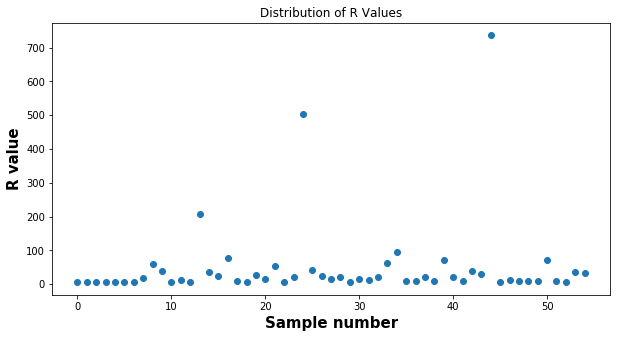

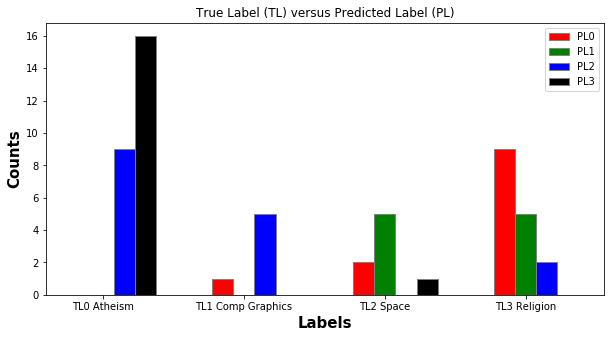

In [31]:
#Find number of R observations above average
average_r = sum(r_arr) / len(r_arr)
average_r
above_average_r_ind = [idx for idx, val in enumerate(r_arr) if val > average_r]
n_above_av_r = len(above_average_r_ind)

#Find number of misclassified items
all_misclassified_r_ind = [idx for idx, val in enumerate(r_arr) if val > 1]
n_all_misclassified = len(all_misclassified_r_ind )

#Plot bar chart of misclassifications where R value is above mean R
def pred_plot(n):
    
    #list of top R indices
    top_n_r_ind = largest_indices(r_arr,n)

    #List of top R values 
    top_n_r_val =r_arr[top_n_r_ind] 
    
    #Scatter plot of R values
    plt.figure(figsize=(10, 5))
    ax = plt.plot()
    
    #Plot R value Distribution
    plt.scatter(range(n), top_n_r_val)
    plt.xlabel("Sample number" , fontweight ='bold', fontsize = 15)
    plt.ylabel("R value" , fontweight ='bold', fontsize = 15)
    plt.title('Distribution of R Values' )
    print('\n')

    #Plot Bar Chart
    # set width of bar
    barWidth = 0.15
    fig = plt.subplots(figsize =(10, 5))
    
    predict_label_0 = [ 0 , 0 , 0 , 0 ]
    predict_label_1 = [ 0 , 0 , 0 , 0 ]
    predict_label_2 = [ 0 , 0 , 0 , 0 ]
    predict_label_3 = [ 0 , 0 , 0 , 0 ]
    
    #For predicted value, find count across true label values
    for i in range(n):
        for k in range(4):
            if r_ind_list[top_n_r_ind[i]][0]==0  and r_ind_list[top_n_r_ind[i]][1]==k:
                predict_label_0[k] += 1
            elif r_ind_list[top_n_r_ind[i]][0]==1  and r_ind_list[top_n_r_ind[i]][1]==k:
                predict_label_1[k] += 1
            elif r_ind_list[top_n_r_ind[i]][0]==2  and r_ind_list[top_n_r_ind[i]][1]==k:
                predict_label_2[k] += 1
            elif r_ind_list[top_n_r_ind[i]][0]==3  and r_ind_list[top_n_r_ind[i]][1]==k:
                predict_label_3[k] += 1
                
                
    # Set position of bar on X axis
    br1 = np.arange(len(predict_label_0))
    #br1 = np.array([-0.5,0.5,1.5,2.5])#np.arange(len(predict_label_0))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]            
        
    # Make the plot
    plt.bar(br1, predict_label_0, color ='r', width = barWidth,
    edgecolor ='grey', label ='PL0')
    plt.bar(br2, predict_label_1, color ='g', width = barWidth,
    edgecolor ='grey', label ='PL1')
    plt.bar(br3, predict_label_2, color ='b', width = barWidth,
    edgecolor ='grey', label ='PL2')
    plt.bar(br4, predict_label_3, color ='black', width = barWidth,
    edgecolor ='grey', label ='PL3')
        
    
    # Adding Xticks
    plt.xlabel('Labels', fontweight ='bold', fontsize = 15)
    plt.ylabel('Counts', fontweight ='bold', fontsize = 15)
    plt.xticks([r + barWidth for r in range(len(predict_label_0))],['TL0 Atheism', 'TL1 Comp Graphics', 'TL2 Space', 'TL3 Religion'])
    plt.title('True Label (TL) versus Predicted Label (PL)')
    plt.legend()
    plt.show()
    
print('Analysis of ' + str(n_above_av_r) +' observations above mean R')
pred_plot(n_above_av_r)
print('\n')
print('\n')



### ANSWER: The differences between TdidfVectorizer and CountVectorizer are as follows:

1. TfidfVectorizer() returns scores in the form of floats while the CountVectorizer() returns integers of the count of the term frequency in the text.

2. Unlike CountVectorizer, TfidfVectorizer weights the term frequency by multiplying by the log of the total number of documents divided by number of documents where the term appears (Inverse document frequency). This effect serves to reduce the weight of less meaningful terms which occur frequently to prevent obscuring of more meaningful terms which occur less frequently.



### ANSWER : Top 3 R Values 

For samples with the Top 3 R values, the model is misclassifying "Topic 3 Religion" as "Topic 0 Atheism" or "Topic 1 Comp Graphics".


#### Issue and Cause:

Religion is misclassified as Comp Graphics : Generally used terms such as 'ftp' are found postings under Religion which is misleading to the model. 

#### Solution:
To address the issue, we can remove the noise by specifying a list of stopwords which are commonly used but necessariy specific to graphics to remove from the features. 



### R Values above Mean
A supplementary analysis of all R values above the mean R shows that most common misclassifications are  :
- "Topic 0 Atheism" as "Topic 3 Religion" 
- "Topic 0 Atheism" as "Topic 2 Space"
-  "Topic 3 Religion"  as "Topic 0 Atheism"

#### Issue and Causes:

1. A percentage count of simliarities between the the top 100 features by weights of "Topic 3 Religion" and "Topic 0 Atheism" shows that these two topics share more common highly weighted features compared to other topics. 
2. The training set is imbalanced. There is a smaller proportion of atheism and religion examples in the training set compared to space and comp graphics.

#### Solution:
We can solve this by undersampling on Comp Graphics and Space to balance the weights and improve the learning power of the algorithm on Atheism and Religion

